# Trabajo Final de Biología de Sistemas 

- Antonio Elias Sánchez Soto
- Daniela Vento
- Yonathan Villavicencio

## Carga del conjunto de datos

Al revisar el txt previamente se muestran las células y los conteos de genes como una matriz de expresión, es necesario trasponer para tener células x genes

In [44]:
import pandas as pd
import scanpy as sc

df = pd.read_csv("wt_eco_sp2.txt", sep=r"\s+", index_col=0)
print(df.shape)
print(df.index[:5])
print(df.iloc[:5, :5])


(27998, 6076)
Index(['Xkr4', 'Gm1992', 'Gm37381', 'Rp1', 'Rp1.1'], dtype='object')
         AAACCTGAGCTAGGCA  AAACCTGAGGGCACTA  AAACCTGAGTAGGTGC  \
Xkr4                    0                 0                 0   
Gm1992                  0                 0                 0   
Gm37381                 0                 0                 0   
Rp1                     0                 0                 0   
Rp1.1                   0                 0                 0   

         AAACCTGAGTTAACGA  AAACCTGCAAGCCATT  
Xkr4                    0                 0  
Gm1992                  0                 0  
Gm37381                 0                 0  
Rp1                     0                 0  
Rp1.1                   0                 0  


In [45]:
adata = sc.AnnData(df.T)  # ahora obs = células, var = genes
print(adata)


AnnData object with n_obs × n_vars = 6076 × 27998


Típicamente antes de la limpieza se aplican las métricas de calidad donde son evaluados los conteos de células y el porcentaje mitocondrial.

In [46]:
adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    percent_top=None,
    log1p=False,
    inplace=True,
)

print(adata.obs[["n_genes_by_counts", "total_counts", "pct_counts_mt"]].describe())


       n_genes_by_counts  total_counts  pct_counts_mt
count        6076.000000   6076.000000    6076.000000
mean         1964.253785   8482.491935       1.927124
std           805.687898   5608.977891       1.139059
min           779.000000   3471.000000       0.022821
25%          1388.000000   5079.750000       1.223945
50%          1801.000000   6897.500000       2.048842
75%          2278.250000   9776.250000       2.524386
max          6563.000000  64943.000000      20.492662


Interpretación: 
- Hay un mínimo de 779 genes por células
- La mayoría de las células tienen profundidades razonables según el cuartil 25% y 75%, sin embargo, existen outliers por el máximo que se muestra 
- La mayoría de las células tiene poco contenido mitocondrial (alrededor del 2%), sin embargo, hay un máximo de 20.49

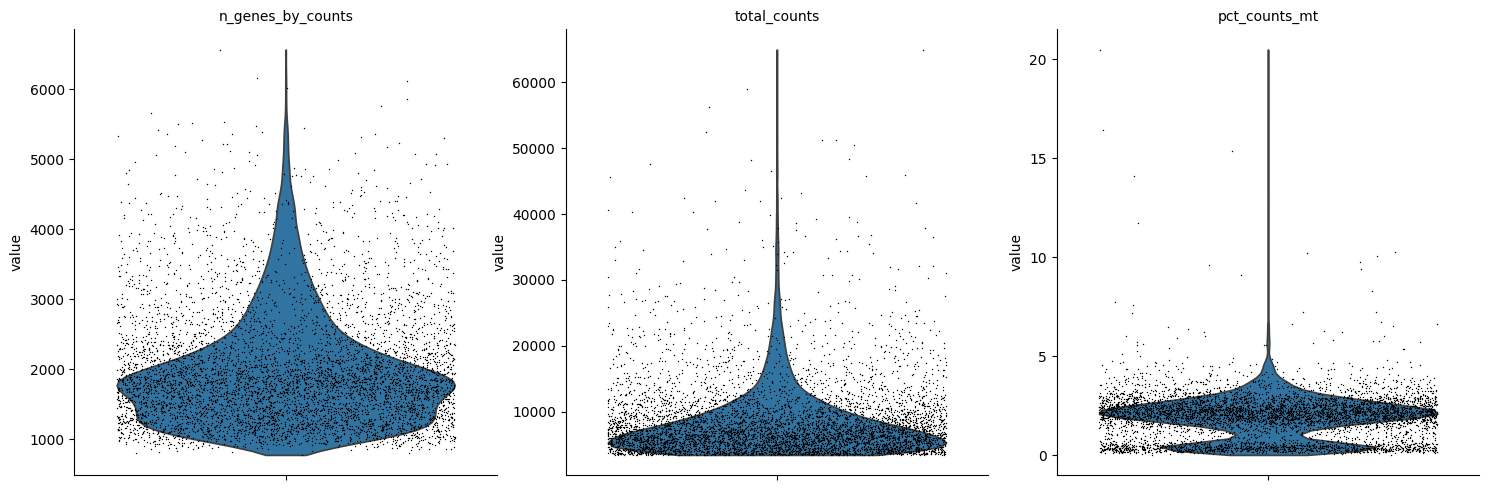

In [47]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True
)

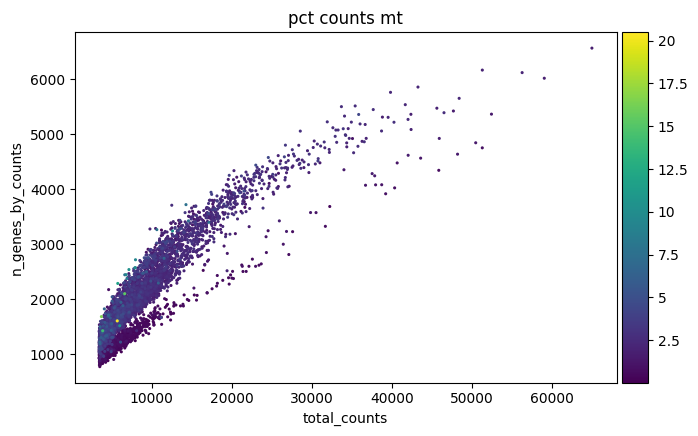

In [48]:
sc.pl.scatter(
    adata,
    x="total_counts",
    y="n_genes_by_counts",
    color="pct_counts_mt"
)


## Filtrado del dataset 

El conjunto de datos debe ser filtrado para que el análisis posterior sea valioso para la investigación. Deben ser eliminados los genes que a penas son detectados (umbral mínimo de 3 conteos). Se deberían filtrar las células aplicando un corte donde tengan cada una al menos 200 genes en su conteo, sin embargo, dado al mínimo de 779 genes, no es necesario hacer este corte. En cuanto al porcentaje de contenido mitocondrial dado los valores bastante bajos en el dataset (a excepción de algunos outliers con un 20%) se podría bajar a un máximo de 5%, siendo así estricto con el estrés/células dañadas.

In [49]:
# Genes expresados en pocas células
sc.pp.filter_genes(adata, min_cells=3)

# Células con pocos genes detectados
#adata = adata[adata.obs["n_genes_by_counts"] > 200, :].copy()

# Células con alto % mitocondrial
adata = adata[adata.obs["pct_counts_mt"] < 5, :].copy()

print("Después de QC, células:", adata.n_obs, "genes:", adata.n_vars)

Después de QC, células: 6030 genes: 14453


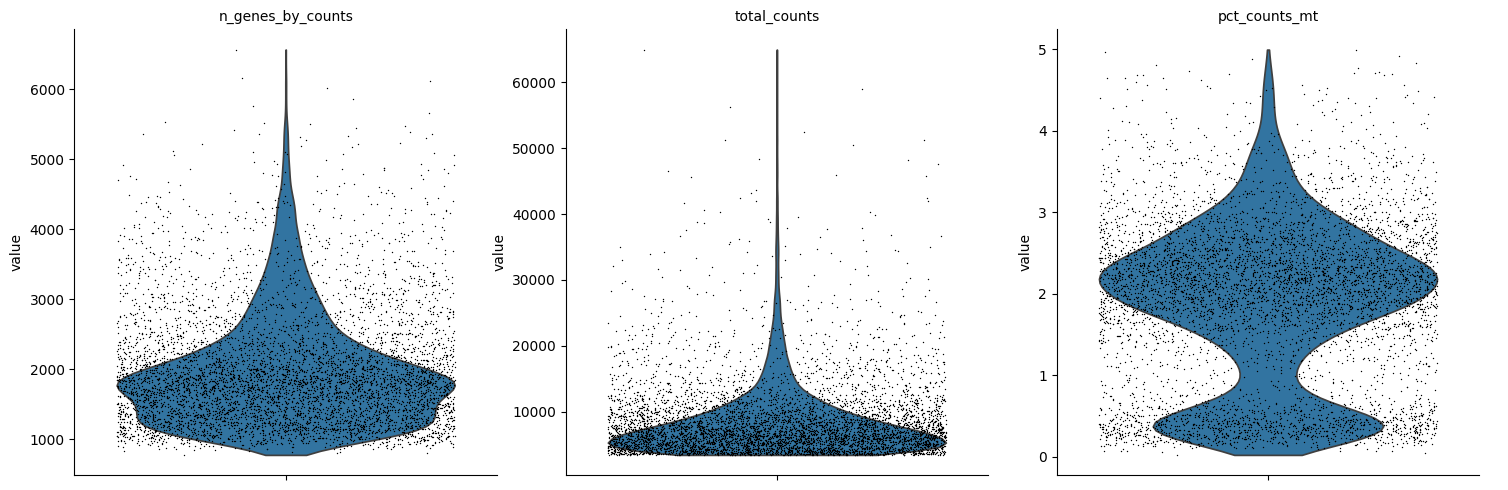

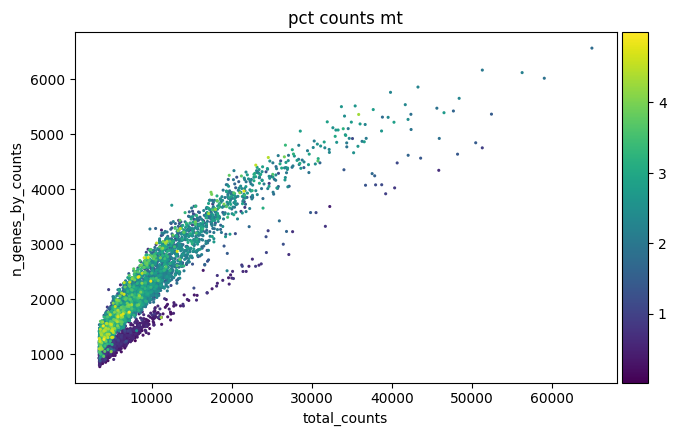

In [50]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True
)

sc.pl.scatter(
    adata,
    x="total_counts",
    y="n_genes_by_counts",
    color="pct_counts_mt"
)


In [51]:
# Normalización por célula (target_sum=1e4 es estándar)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata) # Transformación log

## Genes variables y reducción de dimensionalidad

Quedarse con los genes que varían entre células reduce la dimensionalidad, y permite quedarnos con genes informativos para distinguir tipos celulares y enfermedades.

Queremos que los genes no estén casi siempre apagandos, no sean muy abundantes en las células y se muestren variaciones informativas entre cada célula. Buscar un subconjunto manejable de genes que capturen eficientemente la heterogeneidad biológica entre las células. 

In [52]:
sc.pp.highly_variable_genes(
    adata,
    min_mean=0.0125, # filtrar expresiones medias muy bajas
    max_mean=3, # filtrar expresiones media muy altas
    min_disp=0.5 # mímina variablidad admitida
)

print(adata.var["highly_variable"].sum(), "genes altamente variables")

# Subconjunto a HVGs
adata = adata[:, adata.var["highly_variable"]].copy()


1498 genes altamente variables


Luego de tener clara la variabilidad debe escalarse para que se puedan realizar comparaciones.

In [53]:
sc.pp.scale(adata, max_value=10) # escalar media 0 y varianza 1, con un valor máximo de 10 en std (recorte)

sc.tl.pca(adata, n_comps=50, svd_solver="arpack") #50 componentes principales
print(adata.uns["pca"]["variance_ratio"][:10]) 

[0.09250934 0.05655673 0.03007306 0.02098684 0.01471787 0.00906784
 0.00823792 0.00798315 0.0063974  0.00510936]


## Agrupamiento

Una vez realizado el PCA que reduce la información de los genes en pocas dimensiones se facilita el agrupamiento y aplicación de UMAP. Este último consiste en proyecciones 2D de la estructura global de los datos. Por otro lado, Leiden agrupa las células con perfiles de expresión parecidos en los clusteres que se establecen.

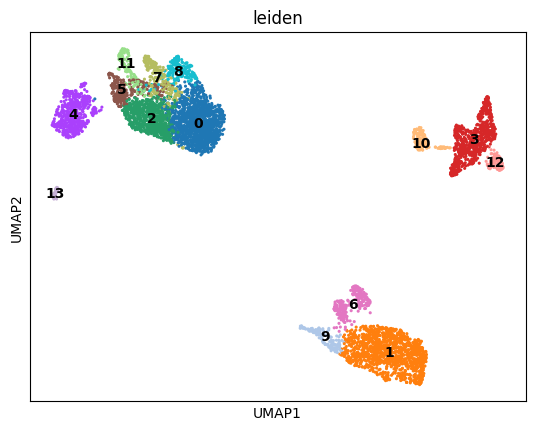

In [54]:
# Vecinos y UMAP
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.umap(adata)

# Clustering Leiden
sc.tl.leiden(adata, resolution=0.5)
# Visualizar clusters
sc.pl.umap(adata, color=["leiden"], legend_loc="on data")

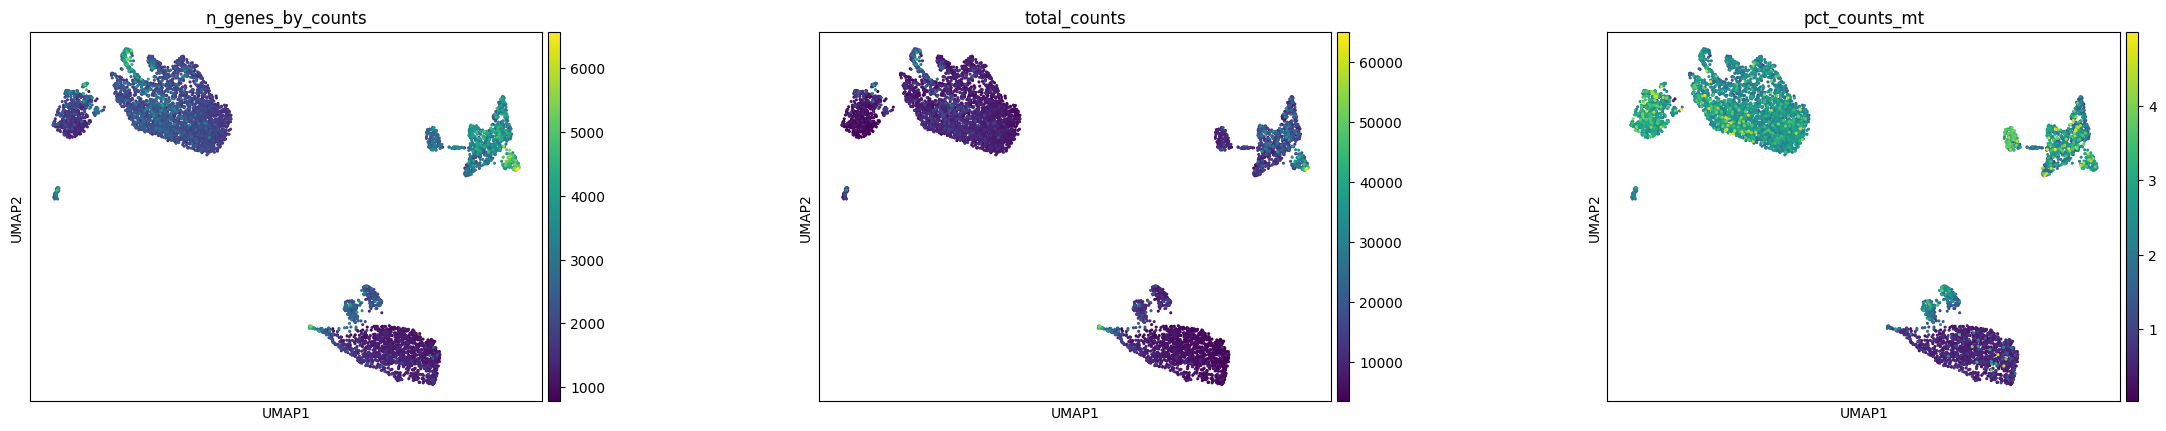

In [55]:
sc.pl.umap(
    adata,
    color=["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    wspace=0.4
)

Por clusters podemos ver cuáles genes están más enriquecidos (marcadores).

## Aplicación de marcadores

Al visualizar los clusters donde se expresan los genes marcadores definidos se pueden asignar tipos celulares al cluster según la firma más presente.

In [ ]:

# Comprobar qué marcadores de tu lista están presentes
marker_genes = [
    "S100a8", "S100a9", "Mmp9", "Csf3r", "Fcgr3", "Bst1",
    "Siglech", "Irf8", "Flt3",
    "Cd3d", "Cd3e", "Il2rb", "Cd4", "Cd8a", "Cd8b1",
    "Ms4a1", "Cd79a", "Cd79b", "Cd19",
    "Ccl9", "Csf1r", "S100a4", "Fcgr3",
]

present = [g for g in marker_genes if g in adata.var_names]
missing = [g for g in marker_genes if g not in adata.var_names]

print("Presentes:", present)
print("Ausentes:", missing)


Index(['Ppp1r42', 'Ly96', 'Tram2', 'Ogfrl1', 'Lmbrd1', 'Ptp4a1', 'Aff3',
       'Gm16152', 'Tbc1d8', 'Rnf149', 'Il1r2', 'Il18r1', 'Il18rap', 'Slc40a1',
       'Pgap1', 'Coq10b', 'Cd28', 'Gm11579', 'Ctla4', 'Icos', 'Klf7',
       'Plekhm3', 'Idh1', 'Ikzf2', 'Fn1', 'Rufy4', 'Cxcr2', 'Cxcr1', 'Slc11a1',
       'Farsb', 'Ap1s3', 'Serpine2', 'Pid1', 'C130026I21Rik', 'A530032D15Rik',
       'A530040E14Rik', 'A630001G21Rik', 'Sag', 'Agap1', 'Hdac4', 'Gpr35',
       'St8sia4', 'Slco4c1', 'Pam', 'Bcl2', 'Serpinb10', 'Ralb', 'Tmem37',
       'Marco', 'Tmem163'],
      dtype='object')
Presentes: ['Mmp9', 'Csf3r', 'Fcgr3', 'Bst1', 'Siglech', 'Irf8', 'Flt3', 'Il2rb', 'Cd4', 'Cd8a', 'Cd8b1', 'Ms4a1', 'Cd79a', 'Cd79b', 'Cd19', 'Ccl9', 'Csf1r', 'S100a4', 'Fcgr3']
Ausentes: ['S100a8', 'S100a9', 'Cd3d', 'Cd3e']


['Mmp9', 'Csf3r', 'Fcgr3', 'Bst1', 'Siglech', 'Irf8', 'Flt3', 'Il2rb', 'Cd4', 'Cd8a', 'Cd8b1', 'Ms4a1', 'Cd79a', 'Cd79b', 'Cd19', 'Ccl9', 'Csf1r', 'S100a4']


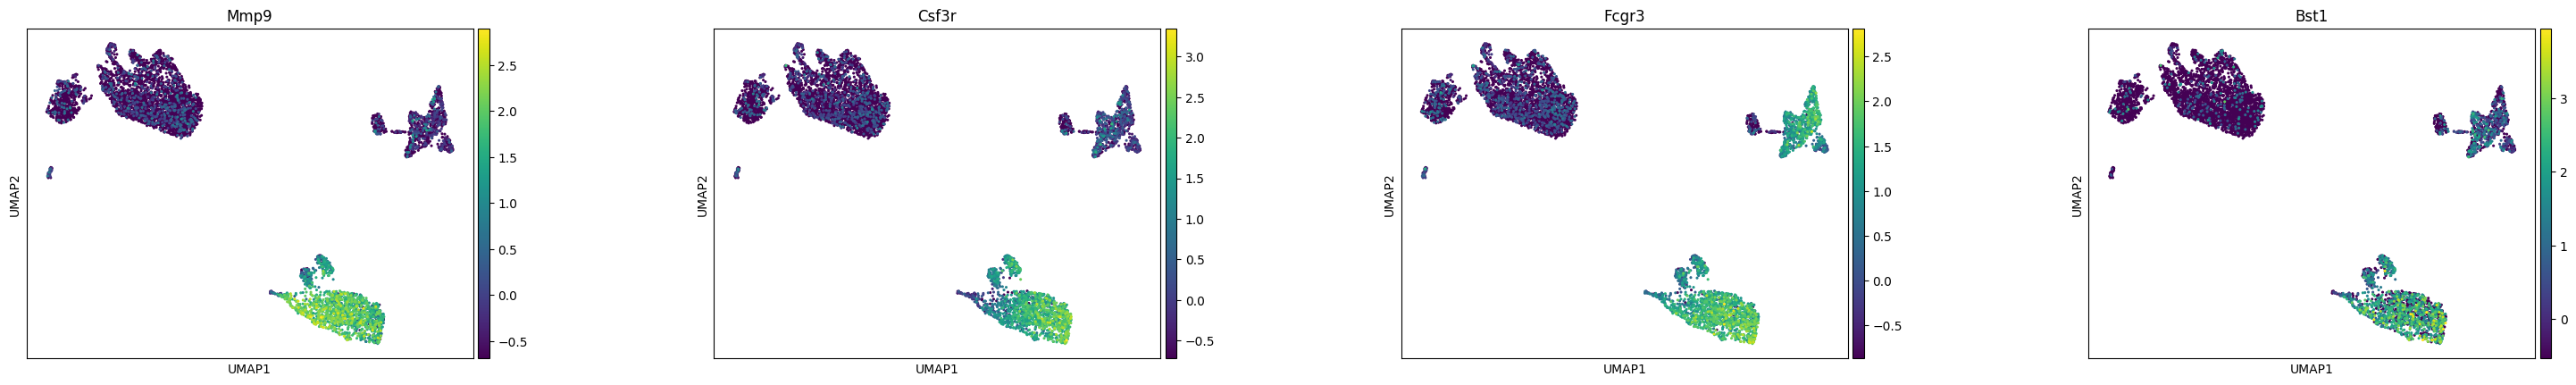

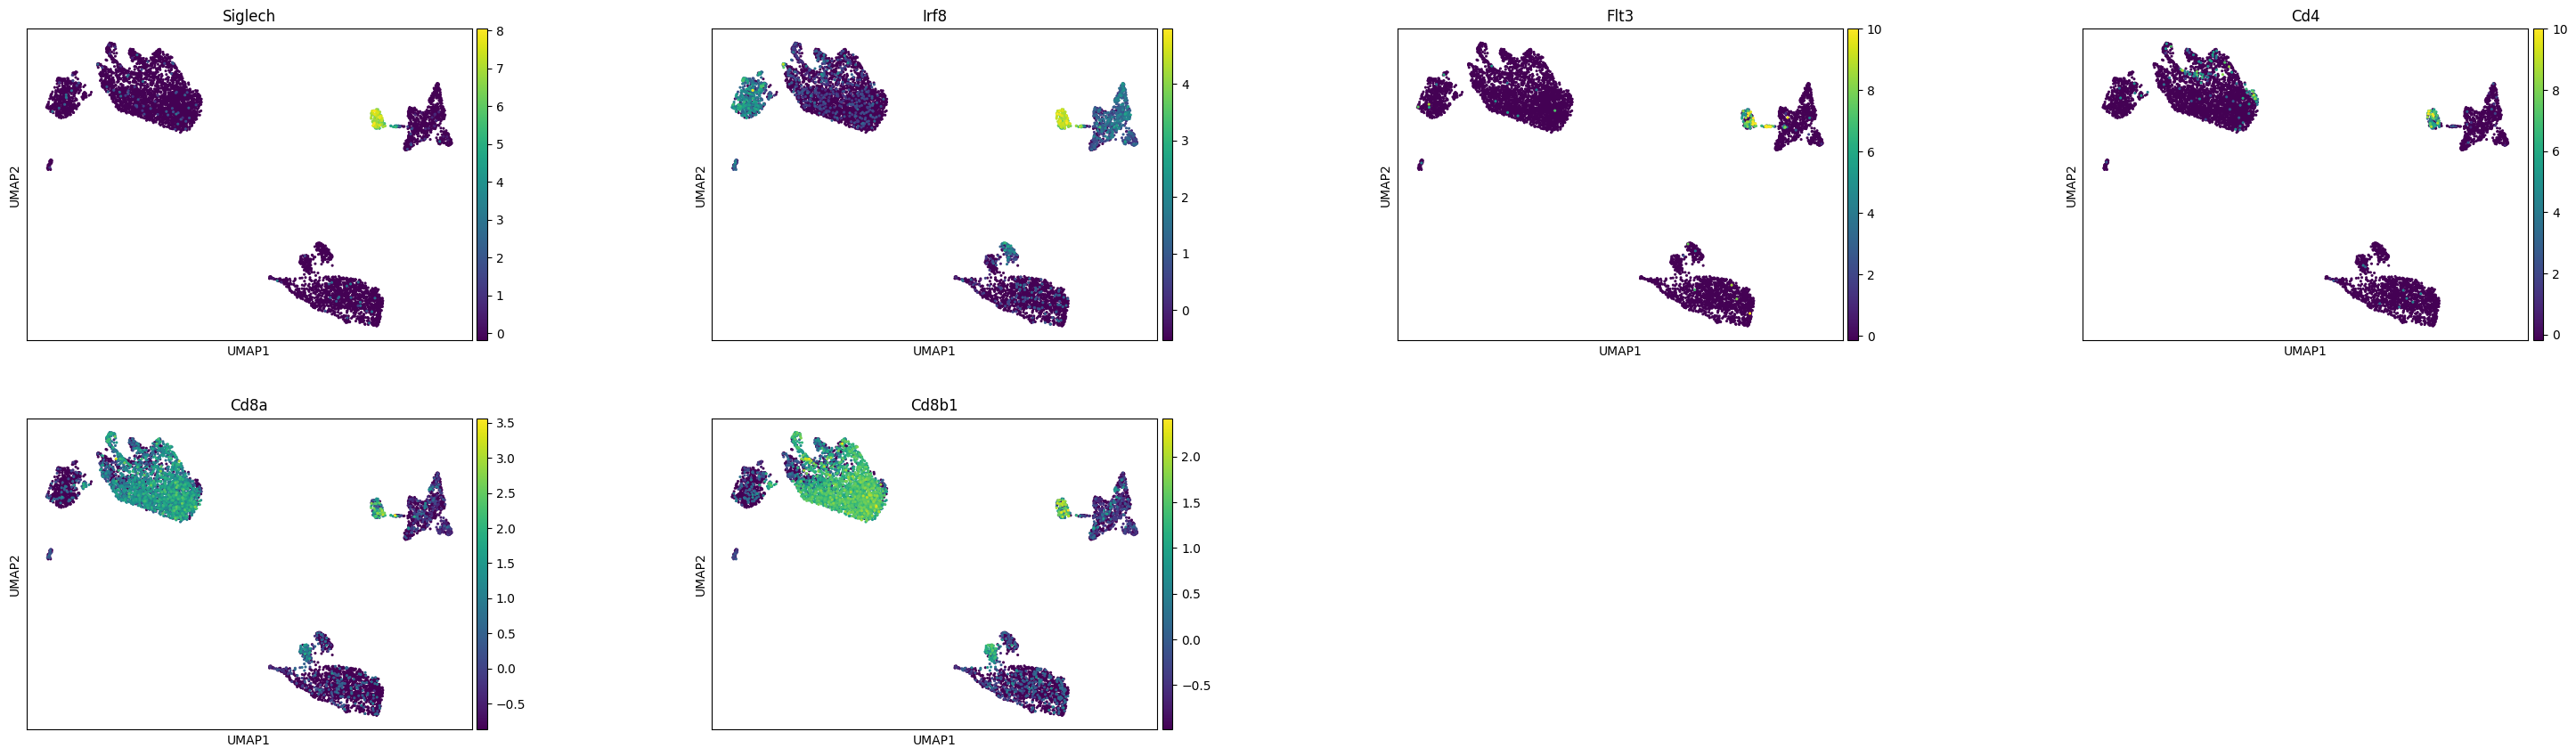

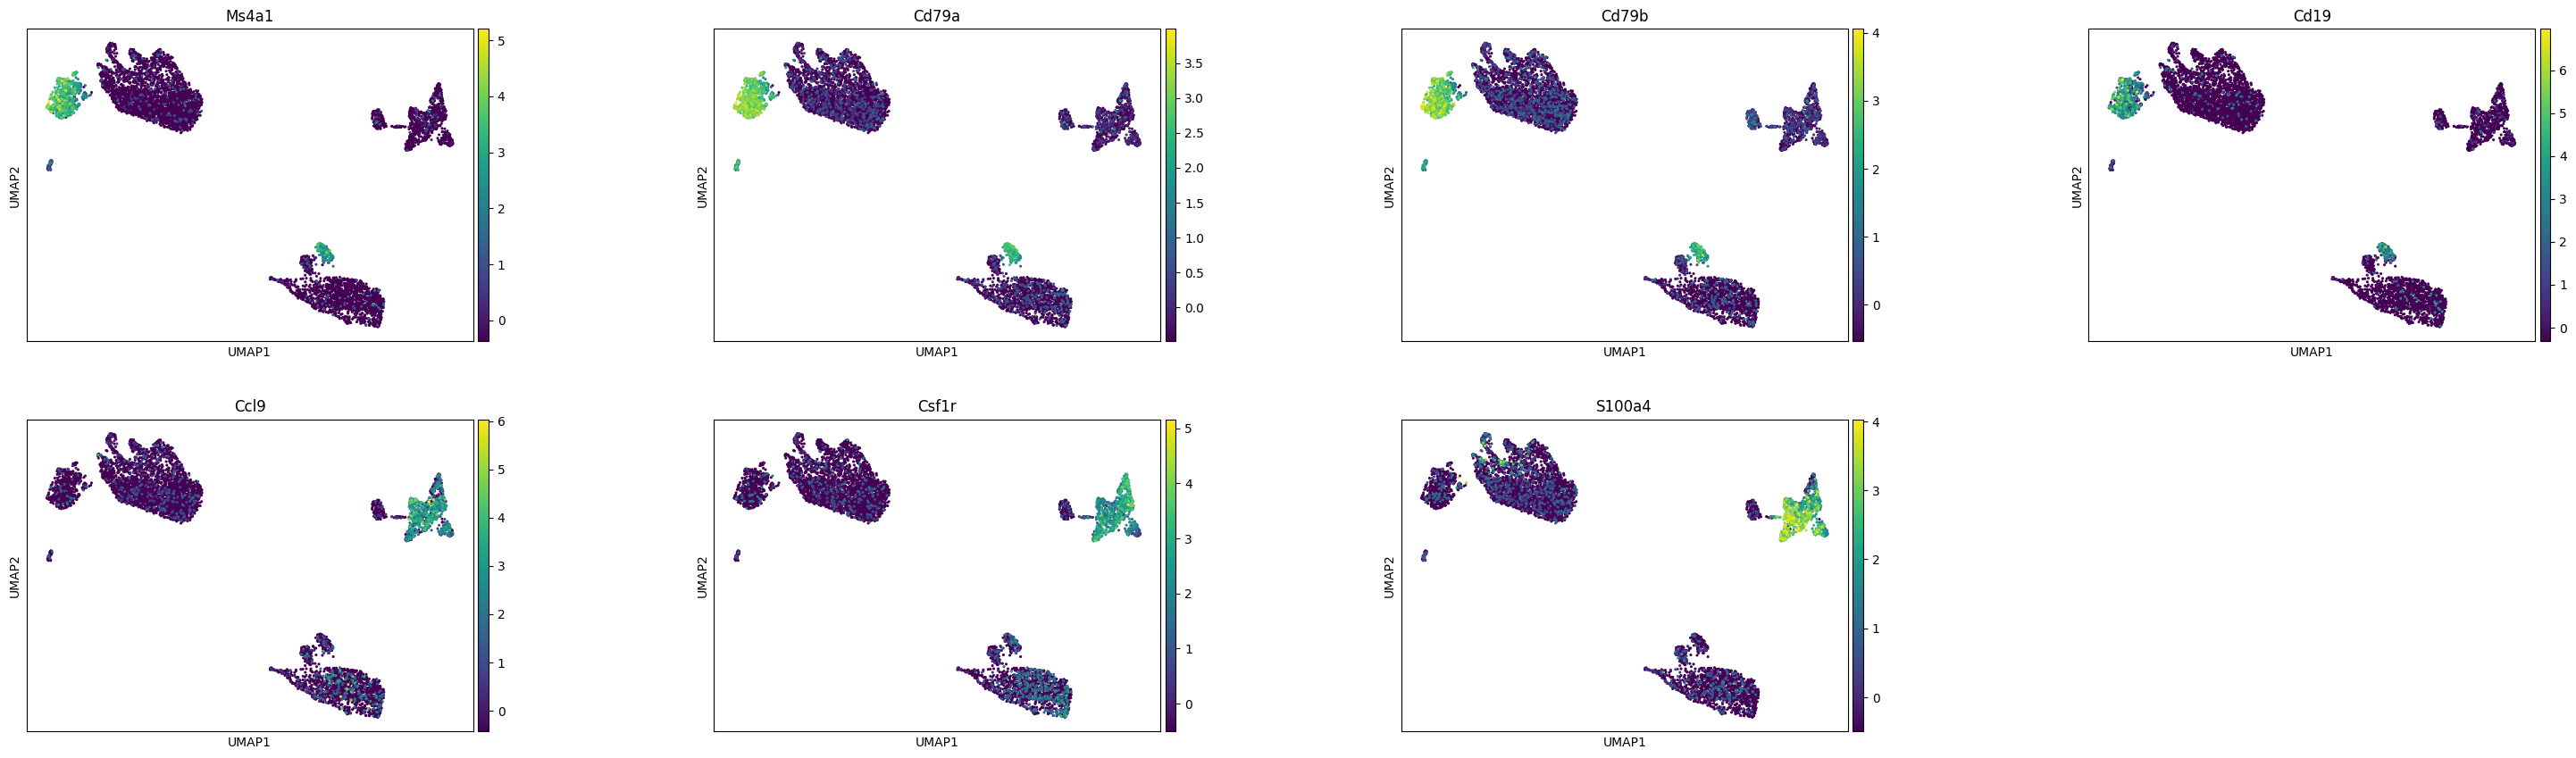

In [63]:
marker_genes = [
    "Mmp9", "Csf3r", "Fcgr3", "Bst1",        # Neutrófilos
    "Siglech", "Irf8", "Flt3",                                  # Dendríticas
    "Il2rb", "Cd4", "Cd8a", "Cd8b1",            # T (CD4/CD8)
    "Ms4a1", "Cd79a", "Cd79b", "Cd19",                          # B
    "Ccl9", "Csf1r", "S100a4",                                  # Monocitos / mieloides
]

# Ver qué genes existen realmente en el dataset
print([g for g in marker_genes if g in adata.var_names])

# UMAP coloreado por cada marcador (hazlo en dos tandas si son muchos)
sc.pl.umap(adata, color=["Mmp9", "Csf3r", "Fcgr3", "Bst1"], wspace=0.4)
sc.pl.umap(adata, color=["Siglech", "Irf8", "Flt3", "Cd4", "Cd8a", "Cd8b1"], wspace=0.4)
sc.pl.umap(adata, color=["Ms4a1", "Cd79a", "Cd79b", "Cd19", "Ccl9", "Csf1r", "S100a4"], wspace=0.4)


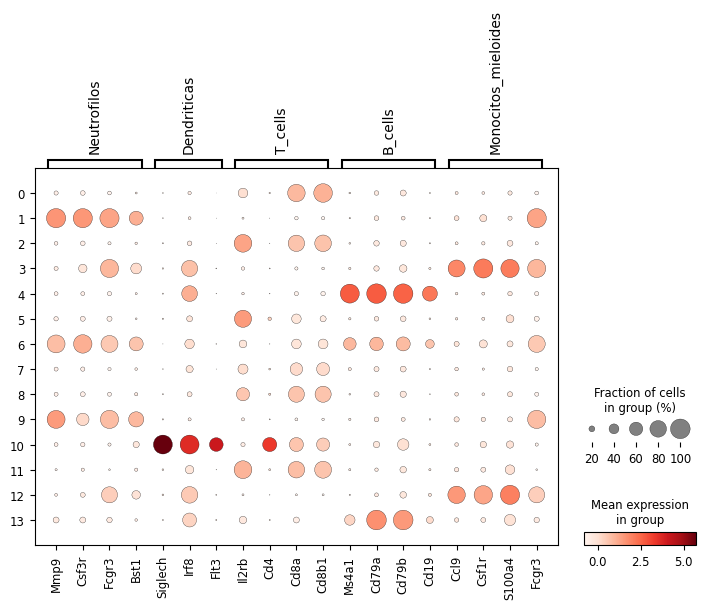

In [64]:
sc.pl.dotplot(
    adata,
    var_names={
        "Neutrofilos": ["Mmp9", "Csf3r", "Fcgr3", "Bst1"],
        "Dendriticas": ["Siglech", "Irf8", "Flt3"],
        "T_cells": ["Il2rb", "Cd4", "Cd8a", "Cd8b1"],
        "B_cells": ["Ms4a1", "Cd79a", "Cd79b", "Cd19"],
        "Monocitos_mieloides": ["Ccl9", "Csf1r", "S100a4", "Fcgr3"],
    },
    groupby="leiden"
)
# tamaño y color indican el porcentaje de células del cluster que expresan el gen, y cuánto